In [1]:
%env ASTERIA=/home/jakob/software/ASTERIA/ASTERIA
from asteria.simulation import Simulation
from astropy.table import Table

import sys # add modules to path
sys.path.insert(0, "/home/jakob/software/ASTERIA/ASTERIA/docs/gen2-ana/seperate")
from analysis import *
from background_trials import *
from signal_hypothesis import *
from plthelper import *

import matplotlib.pyplot as plt

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

env: ASTERIA=/home/jakob/software/ASTERIA/ASTERIA


In [2]:
def plot_significance2(dist_range, zscore, ts_stat):

    fig, ax = plt.subplots(1,2, figsize = (16,6))
    ax = ax.ravel()

    labels = [r'$IceCube$', r'$Gen2$', r'$Gen2+WLS$']
    colors = ['C0', 'C1', 'C2']

    mask = np.where(np.isinf(zscore["ic86"][2])==True, False, True)

    for i, det in enumerate(["ic86", "gen2", "wls"]):
        for j in range(3):
            m = np.isinf(zscore[det][j])
            zscore[det][j][m] = zscore[det][j][np.isfinite(zscore[det][j])].max()
        ax[0].plot(dist_range, zscore[det][0], label=labels[i], color = colors[i])
        ax[0].fill_between(dist_range.value, zscore[det][2], zscore[det][1], color = colors[i], alpha = 0.15)
    
        #signal without errorbar
        ax[1].plot(dist_range, ts_stat["signal"][det][0], color = colors[i], label=r'TS$^{sig}_{IceCube}$')

        #background with errorbar
        ax[1].errorbar(x = dist_range, y = ts_stat["null"][det][0],
                    yerr = (ts_stat["null"][det][0]-ts_stat["null"][det][1],ts_stat["null"][det][2]-ts_stat["null"][det][0]), 
                    capsize=4, ls = ':', color = colors[i], label=r'TS$^{bkg}_{IceCube}$')

    ax[0].set_xlabel('Distance d [kpc]', fontsize = 12)
    ax[0].set_ylabel(r'SASI detection significance [$\sigma$]' , fontsize = 12)
    #ax[0].set_xlim((1,20))
    ax[0].set_ylim((1,30))

    ax[0].tick_params(labelsize = 12)

    ax[0].set_yscale('log')
    ax[0].set_yticks([1,2,3,5,10,20,30])
    ax[0].set_yticklabels(['1','2','3','5','10','20','30'])

    ax[0].grid()
    ax[0].legend(loc='upper right', fontsize = 12)

    ax[0].axhline(3, color='k', ls = ':')
    ax[0].axhline(5, color='k', ls = '-.')
    ax[0].text(dist_range[mask][-1].value, 3, r"3$\sigma$", size=12,
            ha="center", va="center",
            bbox=dict(boxstyle="square", ec='k', fc='white'))

    ax[0].text(dist_range[mask][-1].value, 5, r"5$\sigma$", size=12,
            ha="center", va="center",
            bbox=dict(boxstyle="square", ec='k', fc='white'))

    # distance for CDF value of 0.1, 0.5, etc.
    cdf_val = np.array([0.1,0.5,0.75,0.9,0.95,0.99,1])
    stellar_dist = coverage_to_distance(cdf_val).flatten()
    # cut all stellar_dist and cdf entries that are smaller (larger) than the smallest (largest) entry in dist_range
    mask = np.logical_and(stellar_dist > dist_range.value.min(), stellar_dist < dist_range.value.max())

    ax22 = ax[0].twiny()
    ax22.set_xlim(ax[0].get_xlim())
    ax22.set_xticks(stellar_dist[mask])
    ax22.set_xticklabels((cdf_val[mask]*100).astype(dtype=int), rotation = 0, fontsize = 12)
    ax22.set_xlabel('Cumulative galactic CCSNe distribution \n from Adams et al. (2013) in [%]', fontsize = 12)

    #rearrange legend handels
    handles,labels = ax[1].get_legend_handles_labels()
    handles = [handles[0], handles[3], handles[1], handles[4], handles[2], handles[5]]
    labels = [labels[0], labels[3], labels[1], labels[4], labels[2], labels[5]]

    ax[1].set_xlabel('Distance d [kpc]', fontsize = 12)
    ax[1].set_ylabel('Median of test statistics (TS)', fontsize = 12)
    #ax[1].set_xlim((1,20))
    ax[1].set_yscale('log')
    ax[1].tick_params(labelsize = 12)
    ax[1].legend(handles, labels, ncol = 3, fontsize = 12, bbox_to_anchor=(0.13, 1))
    ax[1].grid()
    plt.tight_layout()

In [3]:
# parsed arguments: distance and sample size
ind_dist = 49
bkg_trials = int(1E4)
bkg_bins = int(2E4)

dist_min, dist_max, dist_step = 0.2, 60, 0.2
dist_range = np.arange(dist_min, dist_max + dist_step, dist_step) * u.kpc
dist_range = np.round(dist_range, 1)
distance = dist_range[ind_dist]

print(f"Distance: {distance}")
print(f"Number of trials: {bkg_trials}")

Distance: 10.0 kpc
Number of trials: 10000


In [4]:
############################################################
######################SIMULATION SETUP######################
############################################################

# detector scope
add_wls = True
detector_scope = "Gen2"

# time resolution
sim_dt = 0.1 * u.ms
res_dt = 0.1 * u.ms


model_name = "RDF_1_7"

if model_name == "RDF_1_2":
    file_path = "~/.astropy/cache/snewpy/models/RDF_1_2/RDF_1_2.dat"
    smoothing_frequency = 50 * u.Hz

elif model_name == "RDF_1_7":
    file_path = "~/.astropy/cache/snewpy/models/RDF_1_7/RDF_1_7.dat"
    smoothing_frequency = 500 * u.Hz

tab = Table().read(file_path, format = "ascii")

# SN model
model = {
    'name': 'Analytic3Species',
    'param': {
        'filename': file_path
    }
}

# neutrino flavor mixing scheme and hierarchy
mixing_scheme = "NoTransformation" #"NoTransformation", "CompleteExchange", "AdiabaticMSW"
hierarchy = "normal" #"normal", "inverted"

sim = Simulation(model=model,
                distance=distance, 
                res_dt=res_dt,
                Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                tmin=tab['TIME'][0]*u.s, tmax=tab['TIME'][-1]*u.s, dt=sim_dt,
                hierarchy = hierarchy,
                mixing_scheme = mixing_scheme,
                detector_scope = detector_scope,
                add_wls = add_wls)
sim.run()


In [30]:
tab["TIME"][-1]

np.float64(1.3399687500000002)

In [20]:
mode = "AMP"
print()
time_win = [0, 10] * u.s

# Initialize analysis class and run analysis
ana = Analysis(sim, res_dt = res_dt, distance=distance)
ana.run(mode = mode, trials = bkg_trials, time_win = time_win, smoothing_frequency = smoothing_frequency)

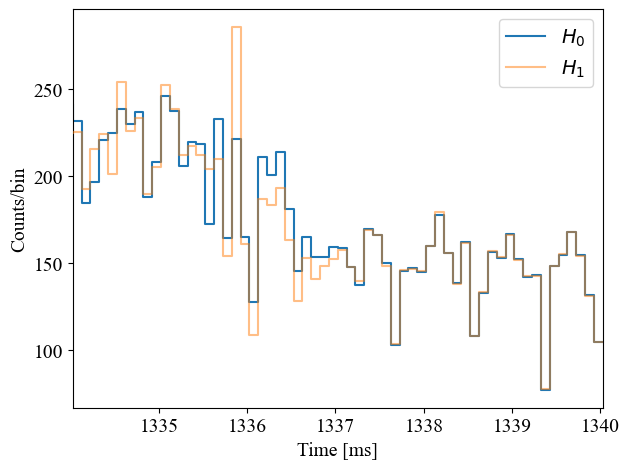

In [21]:
plot_hits(ana._time, ana._comb, det = "ic86")
plt.xlim(ana._time[0].value*1000,ana._time[-1].value*1000)
plt.tight_layout()

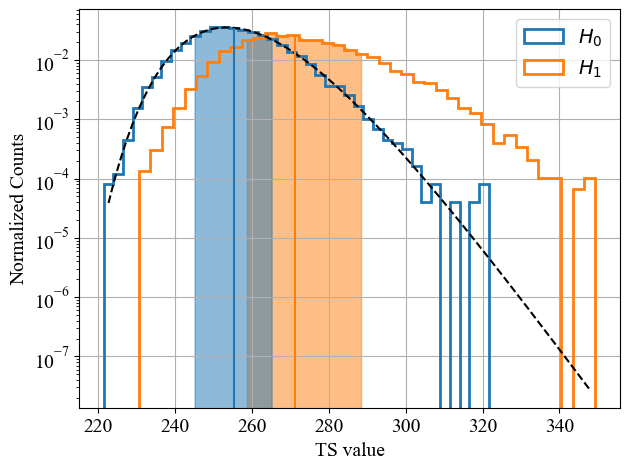

In [22]:
plot_ts(ana.ts, bkg_distr="lognorm")
plt.yscale("log")
plt.tight_layout()

In [25]:
dist_range = np.arange(1,35,1) * u.kpc
trials = int(1E4)
Zscore, Ts_stat = ana.dist_scan(dist_range, mode, trials, time_win, smoothing_frequency, verbose = "debug")

Distance: 1.0 kpc
Distance: 2.0 kpc
Distance: 3.0 kpc
Distance: 4.0 kpc
Distance: 5.0 kpc
Distance: 6.0 kpc
Distance: 7.0 kpc
Distance: 8.0 kpc
Distance: 9.0 kpc
Distance: 10.0 kpc
Distance: 11.0 kpc
Distance: 12.0 kpc
Distance: 13.0 kpc
Distance: 14.0 kpc
Distance: 15.0 kpc
Distance: 16.0 kpc
Distance: 17.0 kpc
Distance: 18.0 kpc
Distance: 19.0 kpc
Distance: 20.0 kpc
Distance: 21.0 kpc
Distance: 22.0 kpc
Distance: 23.0 kpc
Distance: 24.0 kpc
Distance: 25.0 kpc
Distance: 26.0 kpc
Distance: 27.0 kpc
Distance: 28.0 kpc
Distance: 29.0 kpc
Distance: 30.0 kpc
Distance: 31.0 kpc
Distance: 32.0 kpc
Distance: 33.0 kpc
Distance: 34.0 kpc


(1.0, 10.0)

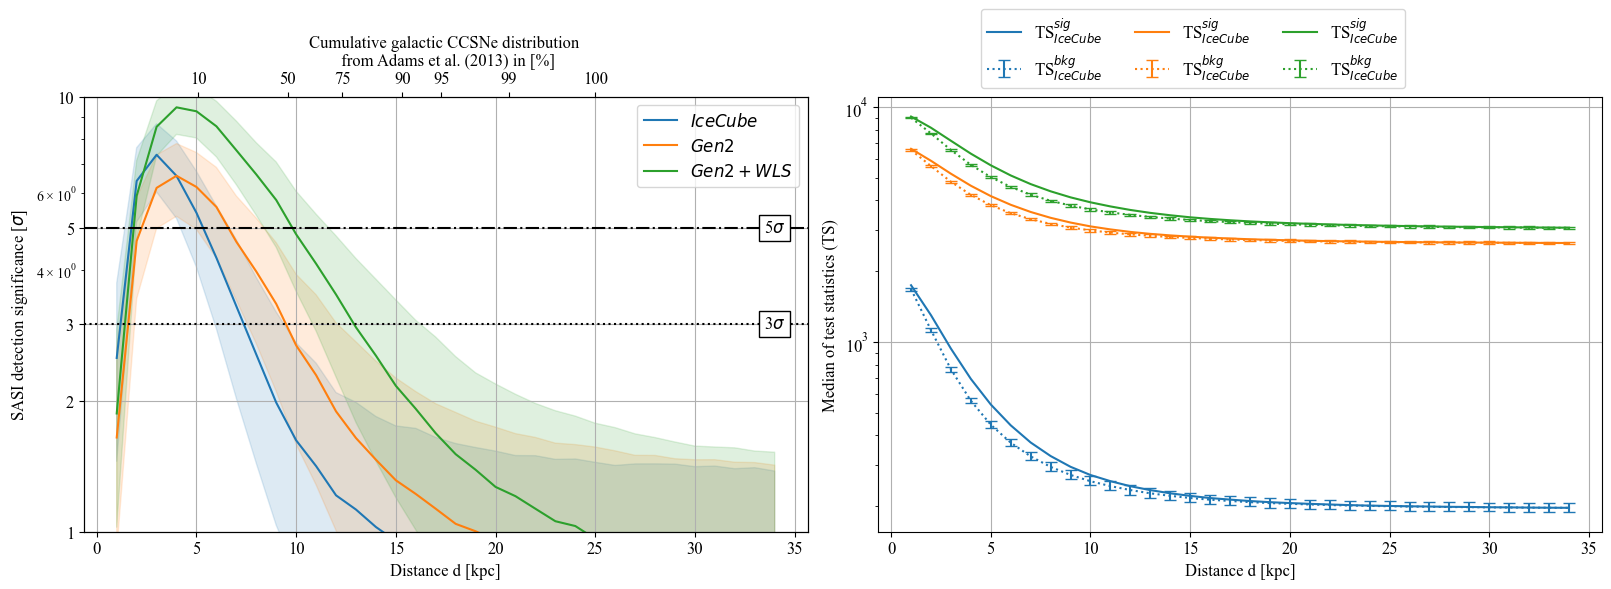

In [34]:
plot_significance2(dist_range, Zscore, Ts_stat)
plt.ylim(1,10)

In [7]:
############################################################
#######################ANALYSIS SETUP#######################
############################################################
bkg_trials = int(1E8)
mode = "AMP"
time_win = [0, 10] * u.s

para = {"mode": mode,
        "model": model_name,
        "hierarchy": hierarchy,
        "mixing_scheme": mixing_scheme,
        "distance": distance,
        "time_win": time_win,
        "smoothing_frequency": smoothing_frequency,
        "bkg_trials": bkg_trials,
        "bkg_bins": bkg_bins}

In [8]:
############################################################
#####################BACKGROUND TRIALS######################
############################################################

print("BACKGROUND TRIALS")
print("-------------------------")
print("mode: {}".format(mode))
print("model: {}".format(model))
print("mixing scheme: {}, hierarchy: {}".format(mixing_scheme, hierarchy))
print("distance: {}".format(distance))
print("time window: {}".format(time_win))
print("smoothing frequency: {}".format(smoothing_frequency))
print("background trials: {}, background bins: {}".format(bkg_trials, bkg_bins))
print("-------------------------")

MODE = "GENERATE"
bgt = Background_Trials(sim = sim, para = para, verbose = True)

if MODE == "GENERATE":
    bgt.generate(filename = None)
elif MODE == "QUANTILE":
    bgt.quantiles(distance_range = dist_range)

BACKGROUND TRIALS
-------------------------
mode: AMP
model: {'name': 'Analytic3Species', 'param': {'filename': '~/.astropy/cache/snewpy/models/RDF_1_2/RDF_1_2.dat'}}
mixing scheme: NoTransformation, hierarchy: normal
distance: 20.0 kpc
time window: [ 0. 10.] s
smoothing frequency: 50.0 Hz
background trials: 100000000, background bins: 20000
-------------------------


 22%|██▏       | 2241/10000 [05:15<18:11,  7.11it/s]


KeyboardInterrupt: 

In [17]:
dir = "/home/jakob/software/ASTERIA/ASTERIA/docs/gen2-ana/seperate/files/background/AMP/default"
filename = "HIST_model_RDF_1_2_mode_AMP_mix_NoTransformation_hier_normal_bkg_trials_1e+06_bins_2e+04_distance_20.0kpc.npz"
path = os.path.join(dir, filename)

data = np.load(path)

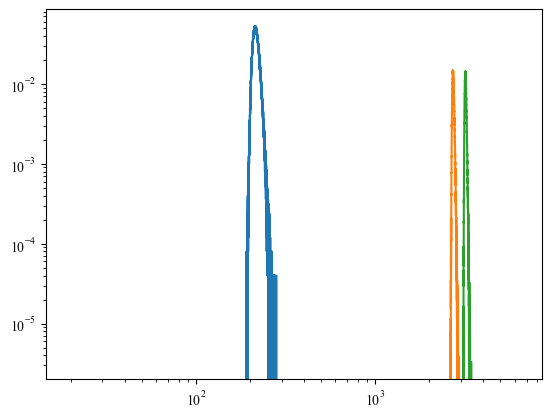

In [22]:
plt.step(data["ic86"][0], data["ic86"][1])
plt.step(data["gen2"][0], data["gen2"][1])
plt.step(data["wls"][0], data["wls"][1])
plt.xscale("log")
plt.yscale("log")

In [5]:
sgh = Signal_Hypothesis(sim, res_dt, distance=10*u.kpc)

In [6]:
dist_range = np.arange(0.2,30.2,0.2) * u.kpc
dist_range = np.round(dist_range, 1)
mode = "AMP"
sig_trials = int(1E4)
bkg_trials = int(1E8)
time_win = [0,10] * u.s
bkg_bin = int(2E4)

Zscore, Ts_stat = sgh.dist_scan(dist_range, mode, sig_trials, bkg_trials, time_win, bkg_bins, verbose = "debug")

Distance: 0.2 kpc
Distance: 0.4 kpc
Distance: 0.6 kpc
Distance: 0.8 kpc
Distance: 1.0 kpc
Distance: 1.2 kpc
Distance: 1.4 kpc
Distance: 1.6 kpc
Distance: 1.8 kpc
Distance: 2.0 kpc
Distance: 2.2 kpc
Distance: 2.4 kpc
Distance: 2.6 kpc
Distance: 2.8 kpc
Distance: 3.0 kpc
Distance: 3.2 kpc
Distance: 3.4 kpc
Distance: 3.6 kpc
Distance: 3.8 kpc
Distance: 4.0 kpc
Distance: 4.2 kpc
Distance: 4.4 kpc
Distance: 4.6 kpc
Distance: 4.8 kpc
Distance: 5.0 kpc
Distance: 5.2 kpc
Distance: 5.4 kpc
Distance: 5.6 kpc
Distance: 5.8 kpc
Distance: 6.0 kpc
Distance: 6.2 kpc
Distance: 6.4 kpc
Distance: 6.6 kpc
Distance: 6.8 kpc
Distance: 7.0 kpc
Distance: 7.2 kpc
Distance: 7.4 kpc
Distance: 7.6 kpc
Distance: 7.8 kpc
Distance: 8.0 kpc
Distance: 8.2 kpc
Distance: 8.4 kpc
Distance: 8.6 kpc
Distance: 8.8 kpc
Distance: 9.0 kpc
Distance: 9.2 kpc
Distance: 9.4 kpc
Distance: 9.6 kpc
Distance: 9.8 kpc
Distance: 10.0 kpc
Distance: 10.2 kpc
Distance: 10.4 kpc
Distance: 10.6 kpc
Distance: 10.8 kpc
Distance: 11.0 kpc
Dist

(1.0, 10.0)

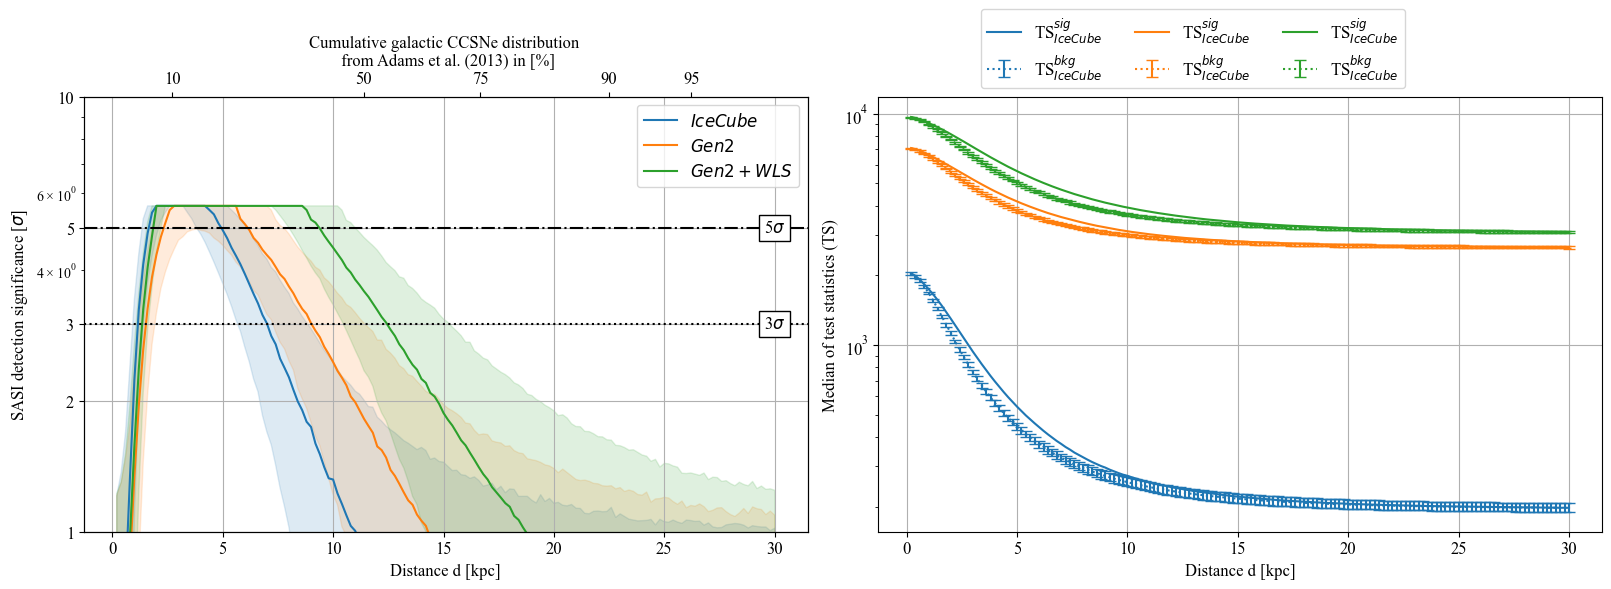

In [11]:
plot_significance2(dist_range, Zscore, Ts_stat)
plt.xlim(3,20)
plt.ylim(1,10)

In [8]:
norm.isf(5)

np.float64(nan)